## **Load Dataset**

In [1]:
import pandas
import numpy as np
import pandas as pd
import os

import keras
from keras.initializers import glorot_uniform
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Input, ZeroPadding2D,Activation,MaxPooling2D,Add,AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from tensorflow.keras import layers
from keras import regularizers
from keras.utils import np_utils
from keras import callbacks
import tensorflow as tf

from skimage.transform import resize
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
EPOCHS = 50 

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices("GPU")

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
#testfile = '/content/drive/MyDrive/enel/archive_lessdata\asl_alphabet_test\asl_alphabet_test'
trainfile = '/content/drive/MyDrive/enel/archive_lessdata_new/archive_lessdata_new2'

### **Plot one picture to test the dataset**

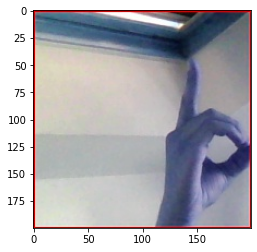


 (200, 200, 3)


In [ ]:
ex = cv2.imread('/content/gdrive/MyDrive/archive_lessdata_new2/D/D1024.jpg')
plt.imshow(ex)
plt.show()
print('\n',ex.shape)

## **Image processing**

**Change RGB images to gray scale**

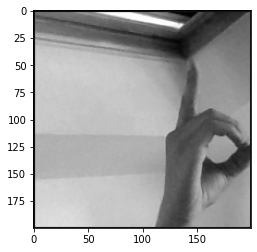

In [ ]:
from skimage import color

ex1 = cv2.cvtColor(ex, cv2.COLOR_BGR2GRAY)
plt.imshow(ex1,cmap = 'gray')

### **Denoising**

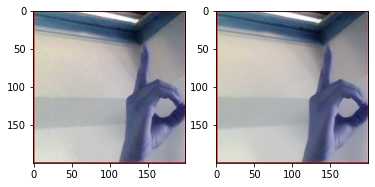

In [ ]:
def denoise(image):
    
    denoised_image = cv2.fastNlMeansDenoisingColored(image,None,h=2)
    
    return denoised_image

denoise_ex = denoise(ex)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(ex)
plt.subplot(1,2,2)
plt.imshow(denoise_ex)

**Visualization**

dataset includes images of 3d ndarray and the shape of (200, 200) with a color image as the size 3

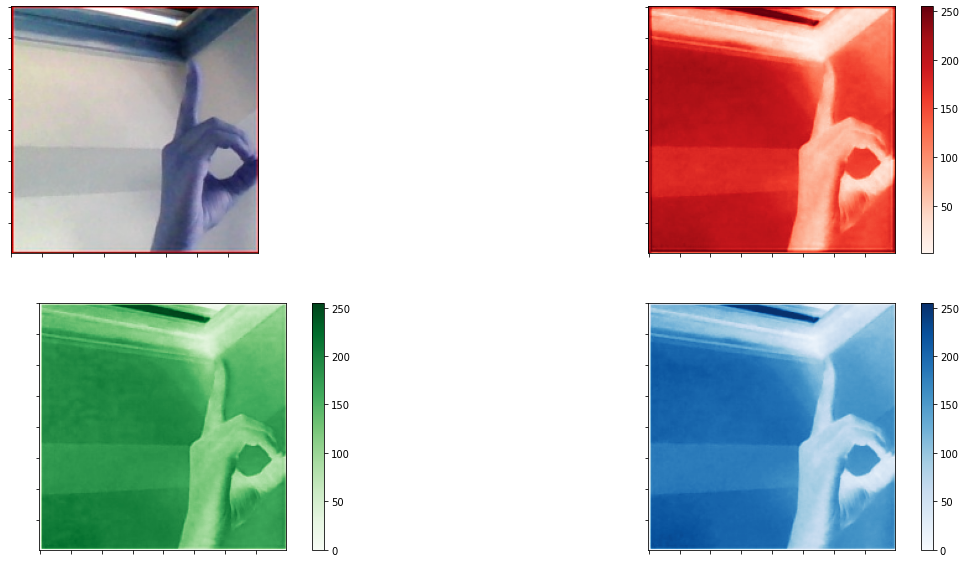

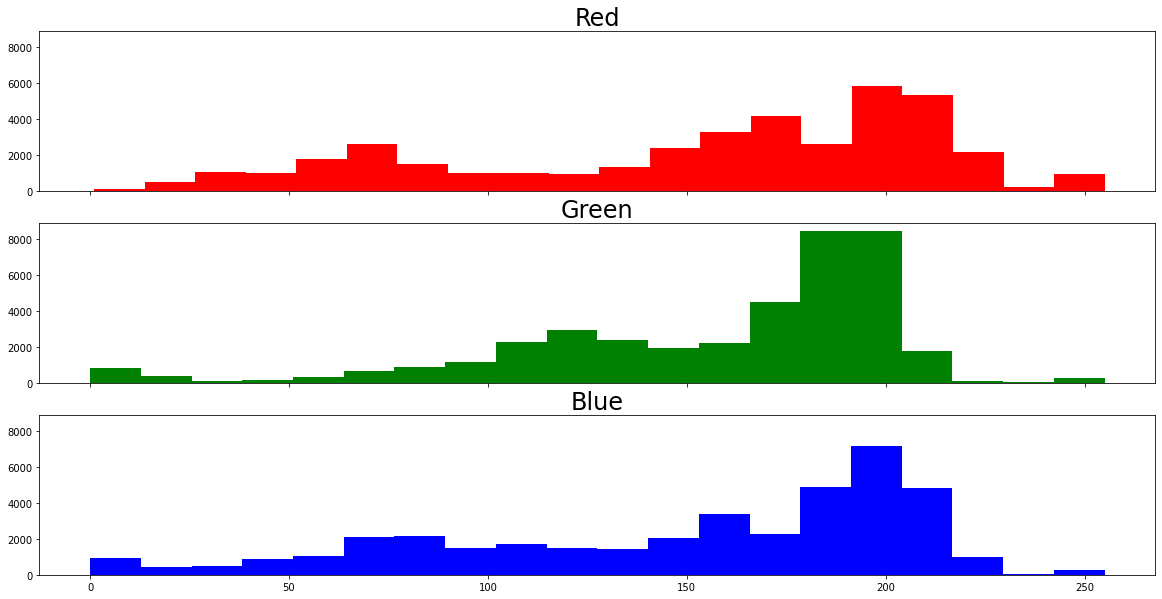

In [ ]:
# color of the image
red = ex[:, :, 0]
blue= ex[:, :, 1]
green = ex[:,:,2]


#set up the figure for plotting
fig, axs = plt.subplots(2,2, figsize=(20, 10))

cax_00 = axs[0,0].imshow(ex)
axs[0,0].xaxis.set_major_formatter(plt.NullFormatter())  # kill xlabels
axs[0,0].yaxis.set_major_formatter(plt.NullFormatter())  # kill ylabels

cax_01 = axs[0,1].imshow(red, cmap='Reds')
fig.colorbar(cax_01, ax=axs[0,1])
axs[0,1].xaxis.set_major_formatter(plt.NullFormatter())
axs[0,1].yaxis.set_major_formatter(plt.NullFormatter())

cax_10 = axs[1,0].imshow(green, cmap='Greens')
fig.colorbar(cax_10, ax=axs[1,0])
axs[1,0].xaxis.set_major_formatter(plt.NullFormatter())
axs[1,0].yaxis.set_major_formatter(plt.NullFormatter())

cax_11 = axs[1,1].imshow(blue, cmap='Blues')
fig.colorbar(cax_11, ax=axs[1,1])
axs[1,1].xaxis.set_major_formatter(plt.NullFormatter())
axs[1,1].yaxis.set_major_formatter(plt.NullFormatter())
plt.show()

#plot histograms
fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize=(20, 10))

axs[0].hist(red.ravel(), bins=20, color = 'red')
axs[0].set_title('Red',fontsize=24)
axs[1].hist(green.ravel(), bins=20, color = 'green')
axs[1].set_title('Green',fontsize=24)
axs[2].hist(blue.ravel(), bins=20, color = 'blue')
axs[2].set_title('Blue',fontsize=24)

plt.show()


*   Preprocess images(resize,denoise,enhance contrast)
*   Defining a dictionary which contains labels and its mapping to a number which acts as class label.
*   loading image data and labels and then mapping those labels to the dictionary defined before.
*   Normalizing image data.
*   converting labels to one hot format as our keras model don't accept categorical label.
*   Normalizing image data.
*   creating training and test data by splitting original data into 95% of training data and 5% testing data.







In [4]:
labels_dict = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,'Z':25,'space':26,'del':27,'nothing':28}

def load_data():

    """
    Loads sign language dataset.
    """
    path = r"/content/gdrive/MyDrive/archive_lessdata_new2"
    images, labels = [], []
    for folder in os.listdir(path):
        
        print(folder, end = ' | ')
        #print(trainfile+"\\"+ folder)
        for image in os.listdir(path+"/"+ folder):
            temp_img = cv2.imread(path+"/"+folder+"/"+image)
            temp_img = cv2.fastNlMeansDenoisingColored(temp_img,None,h=2)
            temp_img = cv2.resize(temp_img, (128,128))
            images.append(temp_img)
            labels.append(labels_dict[folder])

    #convert images to numpy array and normalize        
    images = np.array(images)
    images = images.astype('float32')/255.0
    
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.1, random_state=42)
    
    
    print()
    print('Loaded', len(X_train),'images for training,','Train data shape =',X_train.shape)
    print('Loaded', len(X_test),'images for testing','Test data shape =',X_test.shape)
    
    return X_train, X_test, y_train, y_test

In [5]:
X_train, X_test, y_train, y_test = load_data()

y_train_ = keras.utils.np_utils.to_categorical(y_train,29)
y_test_ = keras.utils.np_utils.to_categorical(y_test,29)

S | X | Z | R | U | V | W | space | Y | T | K | L | O | nothing | M | N | P | I | Q | J | A | D | del | H | C | E | F | G | B | 
Loaded 9135 images for training, Train data shape = (9135, 128, 128, 3)
Loaded 1015 images for testing Test data shape = (1015, 128, 128, 3)


In [ ]:
print("X_train shape  -> ", X_train.shape)
print("X_test shape   -> ", X_test.shape)
print("y_train_ shape -> ", y_train_.shape)
print("y_test_ shape  -> ", y_test_.shape)
print("len y_train    -> ", len(y_train))

X_train shape  ->  (9135, 128, 128, 3)
X_test shape   ->  (1015, 128, 128, 3)
y_train_ shape ->  (9135, 29)
y_test_ shape  ->  (1015, 29)
len y_train    ->  9135


### **Data Augmentation**

In [ ]:
batch_size = 32
gen_params = {"featurewise_center":False, "samplewise_center":False, "featurewise_std_normalization":False,\
              "samplewise_std_normalization":False, "zca_whitening":False, "rotation_range":15,\
              "width_shift_range":0, "height_shift_range":0, "shear_range":0, \
              "zoom_range":0, "fill_mode":'constant', "horizontal_flip":False, "vertical_flip":False
              }

train_gen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params, preprocessing_function = tf.keras.applications.mobilenet.preprocess_input)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params, preprocessing_function = tf.keras.applications.mobilenet.preprocess_input)

train_gen.fit(X_train,seed = 1)
val_gen.fit(X_test, seed = 1)

train_flow = train_gen.flow(X_train,y_train,batch_size = batch_size)
val_flow = val_gen.flow(X_test,y_test,batch_size = batch_size) 

In [ ]:
plt.figure(figsize = (32,24))
Xbatch,Ybatch = train_flow.__getitem__(0)
print(Xbatch.mean(),Xbatch.std())
print(Xbatch.min(),Xbatch.max())
for ii in range(batch_size):
    plt.subplot(7,5,ii+1)
    plt.imshow((Xbatch[ii]- Xbatch[ii].min())/(Xbatch.max() - Xbatch[ii].min()), cmap = "gray")
    plt.title(y_train[ii])
plt.show()

## **Model Implementation (Sequential1)**


*   implementing with keras library activation: activation function, relu metrics : accuracy, optimizer: adam optimizer

*   Adam is one of the most effective optimization algorithms for training neural networks. Some advantages of Adam is that relatively low memory requirements and usually works well even with little tuning of hyperparameters

In [ ]:
# function to create model that receives an optimizer as argument
def create_model(optimizer): 
    # create model 
    model = Sequential() # (The Sequential model is a linear stack of layers)
    model.add(layers.experimental.preprocessing.RandomRotation(0.2, input_shape=(128, 128, 3)))

    #add 64 filters 
    #(3,3) means 3x3 dimension that specifies height & width of the 2d convolution window
    #relu is the name of the activation function to be applied after performing the convolution
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(128, 128, 3), activation='relu'))

    #max pooling to reduce the spatial dimensions of the output volume &reduce overfitting
    model.add(MaxPool2D(pool_size=(2, 2)))
     
    # Relu to help network learn non-linear decision boundary 
    model.add(Conv2D(128, (3, 3), padding='same', input_shape=(128, 128, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3), padding='same', input_shape=(128, 128, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dropout(0.5))

    # sigmoid classifier to predict input class label
    model.add(Dense(512, activation='sigmoid')) # adds an output layer(dense = regular deeply connected neural network layer)

    # softmax classifier to predict input class label
    model.add(Dense(29, activation='softmax'))# adds an output layer #

    # compile or train the model with the optimizer, loss, & metrics
    model.compile(optimizer = optimizer, loss = keras.losses.categorical_crossentropy, metrics = ["accuracy"])
    
    # Summarize the model
    model.summary()
    return model

In [ ]:
def fit_model(model,epochs):
    
    earlystopping = callbacks.EarlyStopping(monitor = 'val_loss', min_delta=0.001, # minimium amount of change to count as an improvement
    patience=23, # how many epochs to wait before stopping
    restore_best_weights = True)
    
    model_hist = model.fit(X_train, y_train_, batch_size = 50, epochs = epochs, validation_split = 0.1, callbacks =[earlystopping])
    
    return model_hist

In [ ]:
print('Train and Baseline Model with adam Optimizer and',50,' epochs') 
model = create_model(optimizer = 'adam')
history = fit_model(model, 50)

Train and Baseline Model with adam Optimizer and 50  epochs
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_1 (RandomRo  (None, 128, 128, 3)      0         
 tation)                                                         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                        

### **Calculate model performance**

In [ ]:
print('Training accuracy:', np.mean(history.history['accuracy']))
print('Training loss:', np.mean(history.history['loss']))
print('Validation accuracy:', np.mean(history.history['val_accuracy']))
print('Validation loss:', np.mean(history.history['val_loss']))

Training accuracy: 0.7712443760037422
Training loss: 0.771307381093502
Validation accuracy: 0.7018161940202117
Validation loss: 1.0109299778938294


### **Plot model performance metrics**

In [ ]:
def plot_performance(hist_model):
    
    plt.plot(hist_model.history['accuracy'])
    plt.plot(hist_model.history['val_accuracy'])
    plt.legend(['training accuracy', 'validation accuracy'], loc='lower right')
    plt.title('accuracy plot - training vs validation')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.savefig('Acc_HighWeightSeq.jpg', dpi=450)
    plt.show()
    
    plt.plot(hist_model.history['loss'])
    plt.plot(hist_model.history['val_loss'])
    plt.legend(['training loss', 'validation loss'], loc = 'upper right')
    plt.title('loss plot - training vs validation')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig('Loss_HighWeightSeq.jpg', dpi=450)
    plt.show()

 Model with preprocesisng with adam Optimizer and 50  epochs


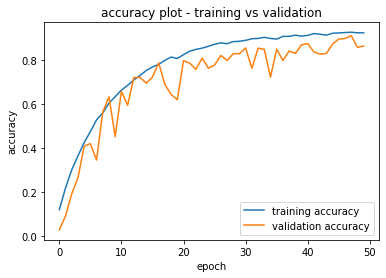

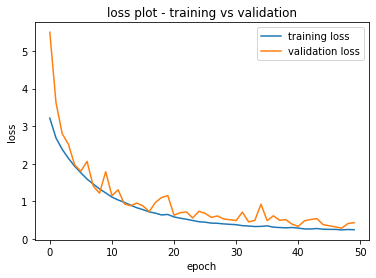

In [ ]:
print(' Model with preprocesisng with adam Optimizer and',EPOCHS,' epochs') 
plot_performance(history)

### **Evaluate model on testing dataset**

In [ ]:
def evaluate_model(model):
    test_loss,test_acc = model.evaluate(X_test, y_test_)
    print('Test accuracy:', test_acc)
    print('Test loss:', test_loss)
    
evaluate_model(model)

32/32 [==============================] - 2s 43ms/step - loss: 0.3722 - accuracy: 0.8778
Test accuracy: 0.8778325319290161
Test loss: 0.37216782569885254


In [6]:
model = "/content/gdrive/MyDrive/Sequential-HighWeight.h5"
model = keras.models.load_model(model)

In [8]:
from sklearn.metrics import classification_report
trainfile = "/content/gdrive/MyDrive/archive_lessdata_new2"
uniq_labels = sorted(os.listdir(trainfile))

y_pred = np.argmax(model.predict(X_test),1)
print(classification_report(y_test,y_pred))

print("Precision : {:.2f} %".format(precision_score(y_pred,y_test,average='macro')))
print("Recall    : {:.2f} %".format(precision_score(y_pred,y_test,average='macro')))
print("F1 Score  : {:.2f} %".format(precision_score(y_pred,y_test,average='macro')))

              precision    recall  f1-score   support

           0       0.85      0.70      0.77        33
           1       0.67      0.97      0.79        29
           2       0.94      0.97      0.95        31
           3       0.98      0.95      0.97        44
           4       0.70      1.00      0.83        31
           5       1.00      0.98      0.99        44
           6       0.94      0.62      0.74        26
           7       1.00      0.89      0.94        35
           8       1.00      0.81      0.89        31
           9       1.00      0.97      0.99        36
          10       0.93      0.78      0.85        36
          11       1.00      0.81      0.90        32
          12       0.85      0.93      0.89        30
          13       0.89      0.74      0.81        34
          14       1.00      0.91      0.95        34
          15       0.97      1.00      0.99        35
          16       1.00      0.94      0.97        32
          17       0.93    

### **Save Model**

In [ ]:
def save_model(model, name):
        model_to_save = model
        model_to_save.save(name + '.h5')
        print("Model successfully Saved.")

save_model(model, "Sequential-HighWeight")

Model successfully Saved.


### **GRAD-CAM Visualization**

In [ ]:
model = "/content/gdrive/MyDrive/Sequential-HighWeight.h5"
model = keras.models.load_model(model)

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
        

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()
    heatmap_resized = resize(heatmap,(128, 128))
    return heatmap_resized

In [ ]:
from tensorflow import keras as K
last_conv_layer_name = list(filter(lambda x: isinstance(x, 
                                                        K.layers.Conv2D), 
                                   model.layers))[-1].name
print(last_conv_layer_name)

conv2d_5


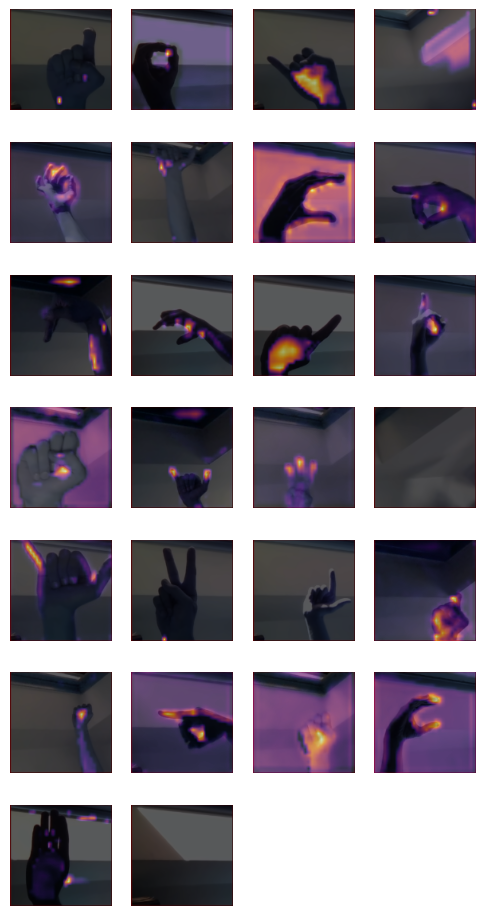

In [ ]:
# Remove last layer's 
model.layers[-1].activation = None

plt.figure(figsize = (6,12),dpi = 100)

for ii in range (26):
    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(X_test[ii][np.newaxis,:,:], model, last_conv_layer_name)
    plt.subplot(7,4,ii+1)
    plt.imshow(X_test[ii])
    plt.imshow(heatmap, alpha = 0.65, cmap = "inferno")
    #plt.colorbar()
    plt.axis("off")
plt.savefig('GRAD-CAM_highWeightSeq.jpg', dpi=300)
plt.show()


# Result visualizations and confusion matrix

In [ ]:
predicted_classes = np.argmax(model.predict(X_test), axis=-1)

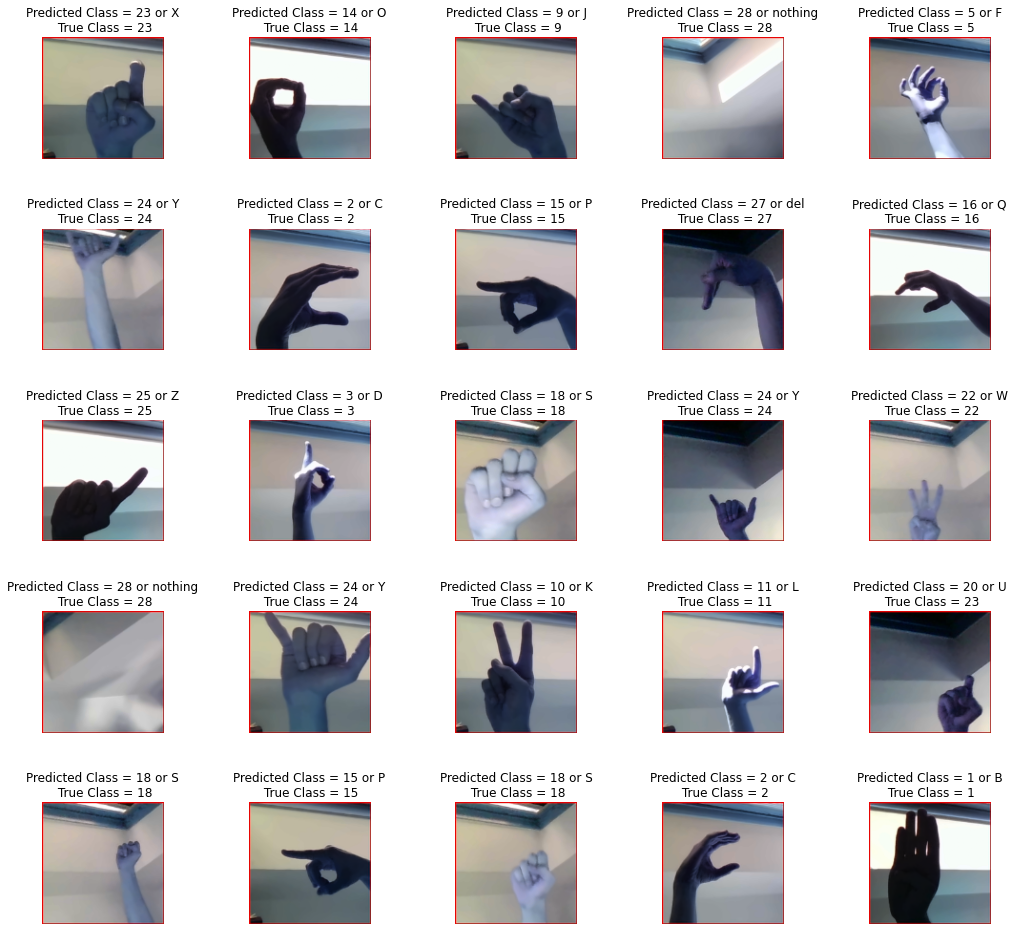

In [ ]:
#Visualize predictions
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (17, 17))
axes = axes.ravel()

for i in np.arange(0, L * W):  
    axes[i].imshow(X_test[i])
    axes[i].set_title(f"Predicted Class = {predicted_classes[i]} or {dict((v,k) for k,v in labels_dict.items()).get(predicted_classes[i])}\n True Class = {y_test[i]}")
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.7)

plt.savefig('predictions_highweightSeq.jpg', dpi=300)

Confusion matrix, without normalization


<Figure size 1440x1440 with 0 Axes>

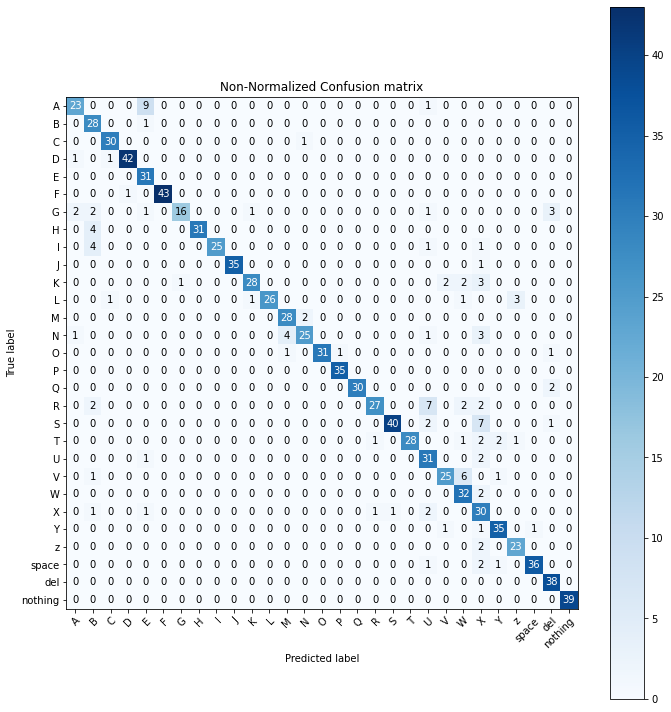

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, predicted_classes)

#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Computing confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

# Visualizing
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(29),
           yticks=np.arange(29),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

   # Rotating the tick labels and setting their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Looping over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

#Specifying class labels
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'z', 'space', 'del', 'nothing']

#Non-Normalized Confusion Matrix
plt.figure(figsize=(20,20))
plot_confusion_matrix(y_test, predicted_classes, classes = class_names, title='Non-Normalized Confusion matrix')
plt.savefig('confmatrix_highWeightSeq.jpg', dpi=300)
plt.show()
